# GAN Model Showcase
This notebook demonstrates how to:
1. Load a pre-trained GAN model
2. Generate synthetic data
3. Visualize results using built-in plotting tools
4. Retrain the model for additional iterations
5. Save and reload the updated model
6. Compare results before and after retraining




In [1]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from model.main import generate_data_from_saved_model, GAN
from model.utils import calc_features, histogram_similarity, composite_metric, compute_trends
from model.plot import plot_distrib, plot_stats, plot_mean_profiles, plot_mean_trends
from model.data_manip import data_prep_wrapper, invert_min_max_scaler, revert_reshape_arr

print("✅ All imports successful!")
print(f"🐍 Python version: {sys.version}")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🎯 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")

✅ All imports successful!
🐍 Python version: 3.11.2 (main, Sep 14 2024, 03:00:30) [GCC 12.2.0]
🔥 PyTorch version: 2.5.0+cu124
🎯 CUDA available: True
🚀 GPU: NVIDIA GeForce RTX 4070 Ti


### 📂 Set up paths and load data
We'll use a pre-trained model and the original training data for comparison

The data we used for this example can be downloaded from:
https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households/


Before training the model, the profiles with peaks above the 95th percentile of all peaks were excluded to ensure normalisation of the data works fine. The data is normalised between -1 and 1 using the min and max values of the whole dataset.  

In [17]:
# Path to our pre-trained model
MODEL_PATH = Path("runs/London_WGAN_80_20_kicked_out_max_95_percentile/misunderstood-pine-397_2025-05-22-101426550/models/epoch_4950/epoch_4950.pt")

# Load the original training data for comparison
TRAIN_DATA_PATH = Path("runs/London_WGAN_80_20_kicked_out_max_95_percentile/misunderstood-pine-397_2025-05-22-101426550/train_data.csv")
TEST_DATA_PATH = Path("runs/London_WGAN_80_20_kicked_out_max_95_percentile/misunderstood-pine-397_2025-05-22-101426550/test_data.csv")

print(f"📂 Model path: {MODEL_PATH}")
print(f"📊 Model exists: {MODEL_PATH.exists()}")
print(f"📈 Training data exists: {TRAIN_DATA_PATH.exists()}")
print(f"🧪 Test data exists: {TEST_DATA_PATH.exists()}")

# Load training data for visualization comparisons
print("\n🔄 Loading training data...")
train_data = pd.read_csv(TRAIN_DATA_PATH, index_col=0)
train_data.index = pd.to_datetime(train_data.index)
test_data = pd.read_csv(TEST_DATA_PATH, index_col=0)
test_data.index = pd.to_datetime(test_data.index)
arr_dt = train_data.index

print(f"📊 Training data shape: {train_data.shape}")
print(f"📅 Date range: {train_data.index.min()} to {train_data.index.max()}")
print(f"🏠 Number of profiles: {train_data.shape[1]}")
print(f"⏰ Time steps per day: {len(train_data) // 368}")

# Display basic statistics
print(f"\n📈 Training data statistics:")
print(f"   Min value: {train_data.min().min():.4f}")
print(f"   Max value: {train_data.max().max():.4f}")
print(f"   Mean value: {train_data.mean().mean():.4f}")
print(f"   Std value: {train_data.std().mean():.4f}")

📂 Model path: runs/London_WGAN_80_20_kicked_out_max_95_percentile/misunderstood-pine-397_2025-05-22-101426550/models/epoch_4950/epoch_4950.pt
📊 Model exists: True
📈 Training data exists: True
🧪 Test data exists: True

🔄 Loading training data...
📊 Training data shape: (8760, 3050)
📅 Date range: 2013-01-01 00:00:00 to 2013-12-31 23:00:00
🏠 Number of profiles: 3050
⏰ Time steps per day: 23

📈 Training data statistics:
   Min value: 0.0000
   Max value: 7.1970
   Mean value: 0.3883
   Std value: 0.3415


### 🤖 Step 1: Load the pre-trained model and generate synthetic data

In [3]:
print("🔄 Loading pre-trained model and generating synthetic data...")
print(f"📂 Loading model from: {MODEL_PATH}")

# Generate synthetic data using the pre-trained model
# We'll generate the same number of profiles as in our training set
n_profiles = train_data.shape[1]
print(f"🎯 Generating {n_profiles} synthetic profiles...")

# This function loads the model and generates synthetic data
synthetic_data_array = generate_data_from_saved_model(MODEL_PATH, n_profiles=n_profiles)

print(f"✅ Synthetic data generated!")
print(f"📊 Synthetic data shape: {synthetic_data_array.shape}")
print(f"🏠 Number of profiles: {synthetic_data_array.shape[1] - 1}")  # -1 because first column is timestamps

# Extract the actual data (remove timestamp column)
synthetic_data_values = synthetic_data_array[:, 1:].astype(np.float32)
print(f"📈 Synthetic values shape: {synthetic_data_values.shape}")

# Convert to DataFrame for easier handling
synthetic_df = pd.DataFrame(
    synthetic_data_values,
    index=train_data.index[:len(synthetic_data_values)],
    columns=[f"synthetic_{i}" for i in range(synthetic_data_values.shape[1])]
)

print(f"\n📊 Synthetic data statistics:")
print(f"   Min value: {synthetic_df.min().min():.4f}")
print(f"   Max value: {synthetic_df.max().max():.4f}")
print(f"   Mean value: {synthetic_df.mean().mean():.4f}")
print(f"   Std value: {synthetic_df.std().mean():.4f}")

print("\n🎉 Model loaded and synthetic data generated successfully!")


🔄 Loading pre-trained model and generating synthetic data...
📂 Loading model from: runs/London_WGAN_80_20_kicked_out_max_95_percentile/misunderstood-pine-397_2025-05-22-101426550/models/epoch_4950/epoch_4950.pt
🎯 Generating 3050 synthetic profiles...
Successfully loaded model from runs/London_WGAN_80_20_kicked_out_max_95_percentile/misunderstood-pine-397_2025-05-22-101426550/models/epoch_4950/epoch_4950.pt
✅ Synthetic data generated!
📊 Synthetic data shape: (8760, 3051)
🏠 Number of profiles: 3050
📈 Synthetic values shape: (8760, 3050)

📊 Synthetic data statistics:
   Min value: 0.0000
   Max value: 6.8661
   Mean value: 0.3865
   Std value: 0.3446

🎉 Model loaded and synthetic data generated successfully!


### 📊 Step 2: Visualize the results

First we calcualte the features that will be plotted for the real data and the synthetic data. The model which has been loaded was trained on the train dataset which consists of 80% of the dataset. The remaining 20% of the data serve as holdout data to see if the model can generate data which is also similar to the holdout data.

In [4]:
print("📊 Creating visualizations to compare real vs synthetic data...")

# Convert data to numpy arrays for our plotting functions
real_data_array = train_data.values.astype(np.float32)
synthetic_data_array = synthetic_data_values
holdout_data_array = test_data.values.astype(np.float32)

# Calculate features for both datasets (needed for plotting)
real_features = calc_features(real_data_array, axis=0)
synthetic_features = calc_features(synthetic_data_array, axis=0)
holdout_features = calc_features(holdout_data_array, axis=0)

print(f"📈 Calculated features for real data: {real_features.shape}")
print(f"📈 Calculated features for synthetic data: {synthetic_features.shape}")
print(f"📈 Calculated features for holdout data: {holdout_features.shape}")

📊 Creating visualizations to compare real vs synthetic data...
📈 Calculated features for real data: (9, 3050)
📈 Calculated features for synthetic data: (9, 3050)
📈 Calculated features for holdout data: (9, 763)


#### 1. Value Distribution Comparison



📊 Creating value distribution plot between synthetic and training data...


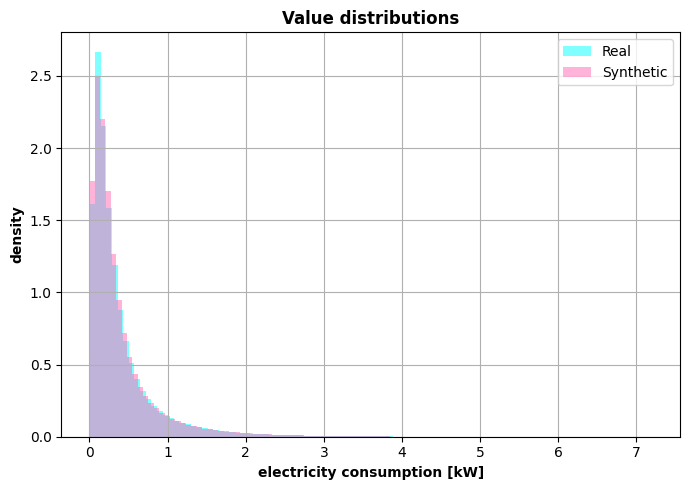

In [5]:
%matplotlib inline
print("\n📊 Creating value distribution plot between synthetic and training data...")
fig_distrib = plot_distrib(real_data_array, synthetic_data_array)
plt.show()


📊 Creating value distribution plot between synthetic and holdout data...


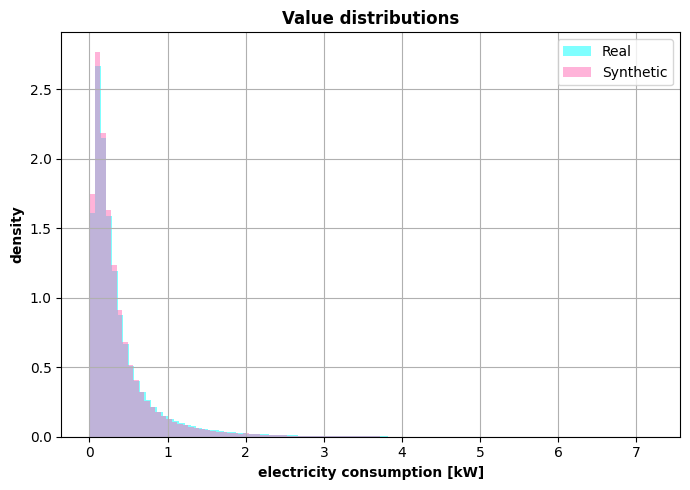

In [6]:
print("\n📊 Creating value distribution plot between synthetic and holdout data...")
fig_distrib = plot_distrib(real_data_array, holdout_data_array)
plt.show()

#### 2. Statistical Features Comparison

The following graphs will show the distribution of different statistical features of all the profiles in each dataset. We compare, means, standard deviation, minima, maxima, median, skew, peak to peak ranges and lower and upper quartiles:





📊 Creating statistical features comparison for training and synthetic data...


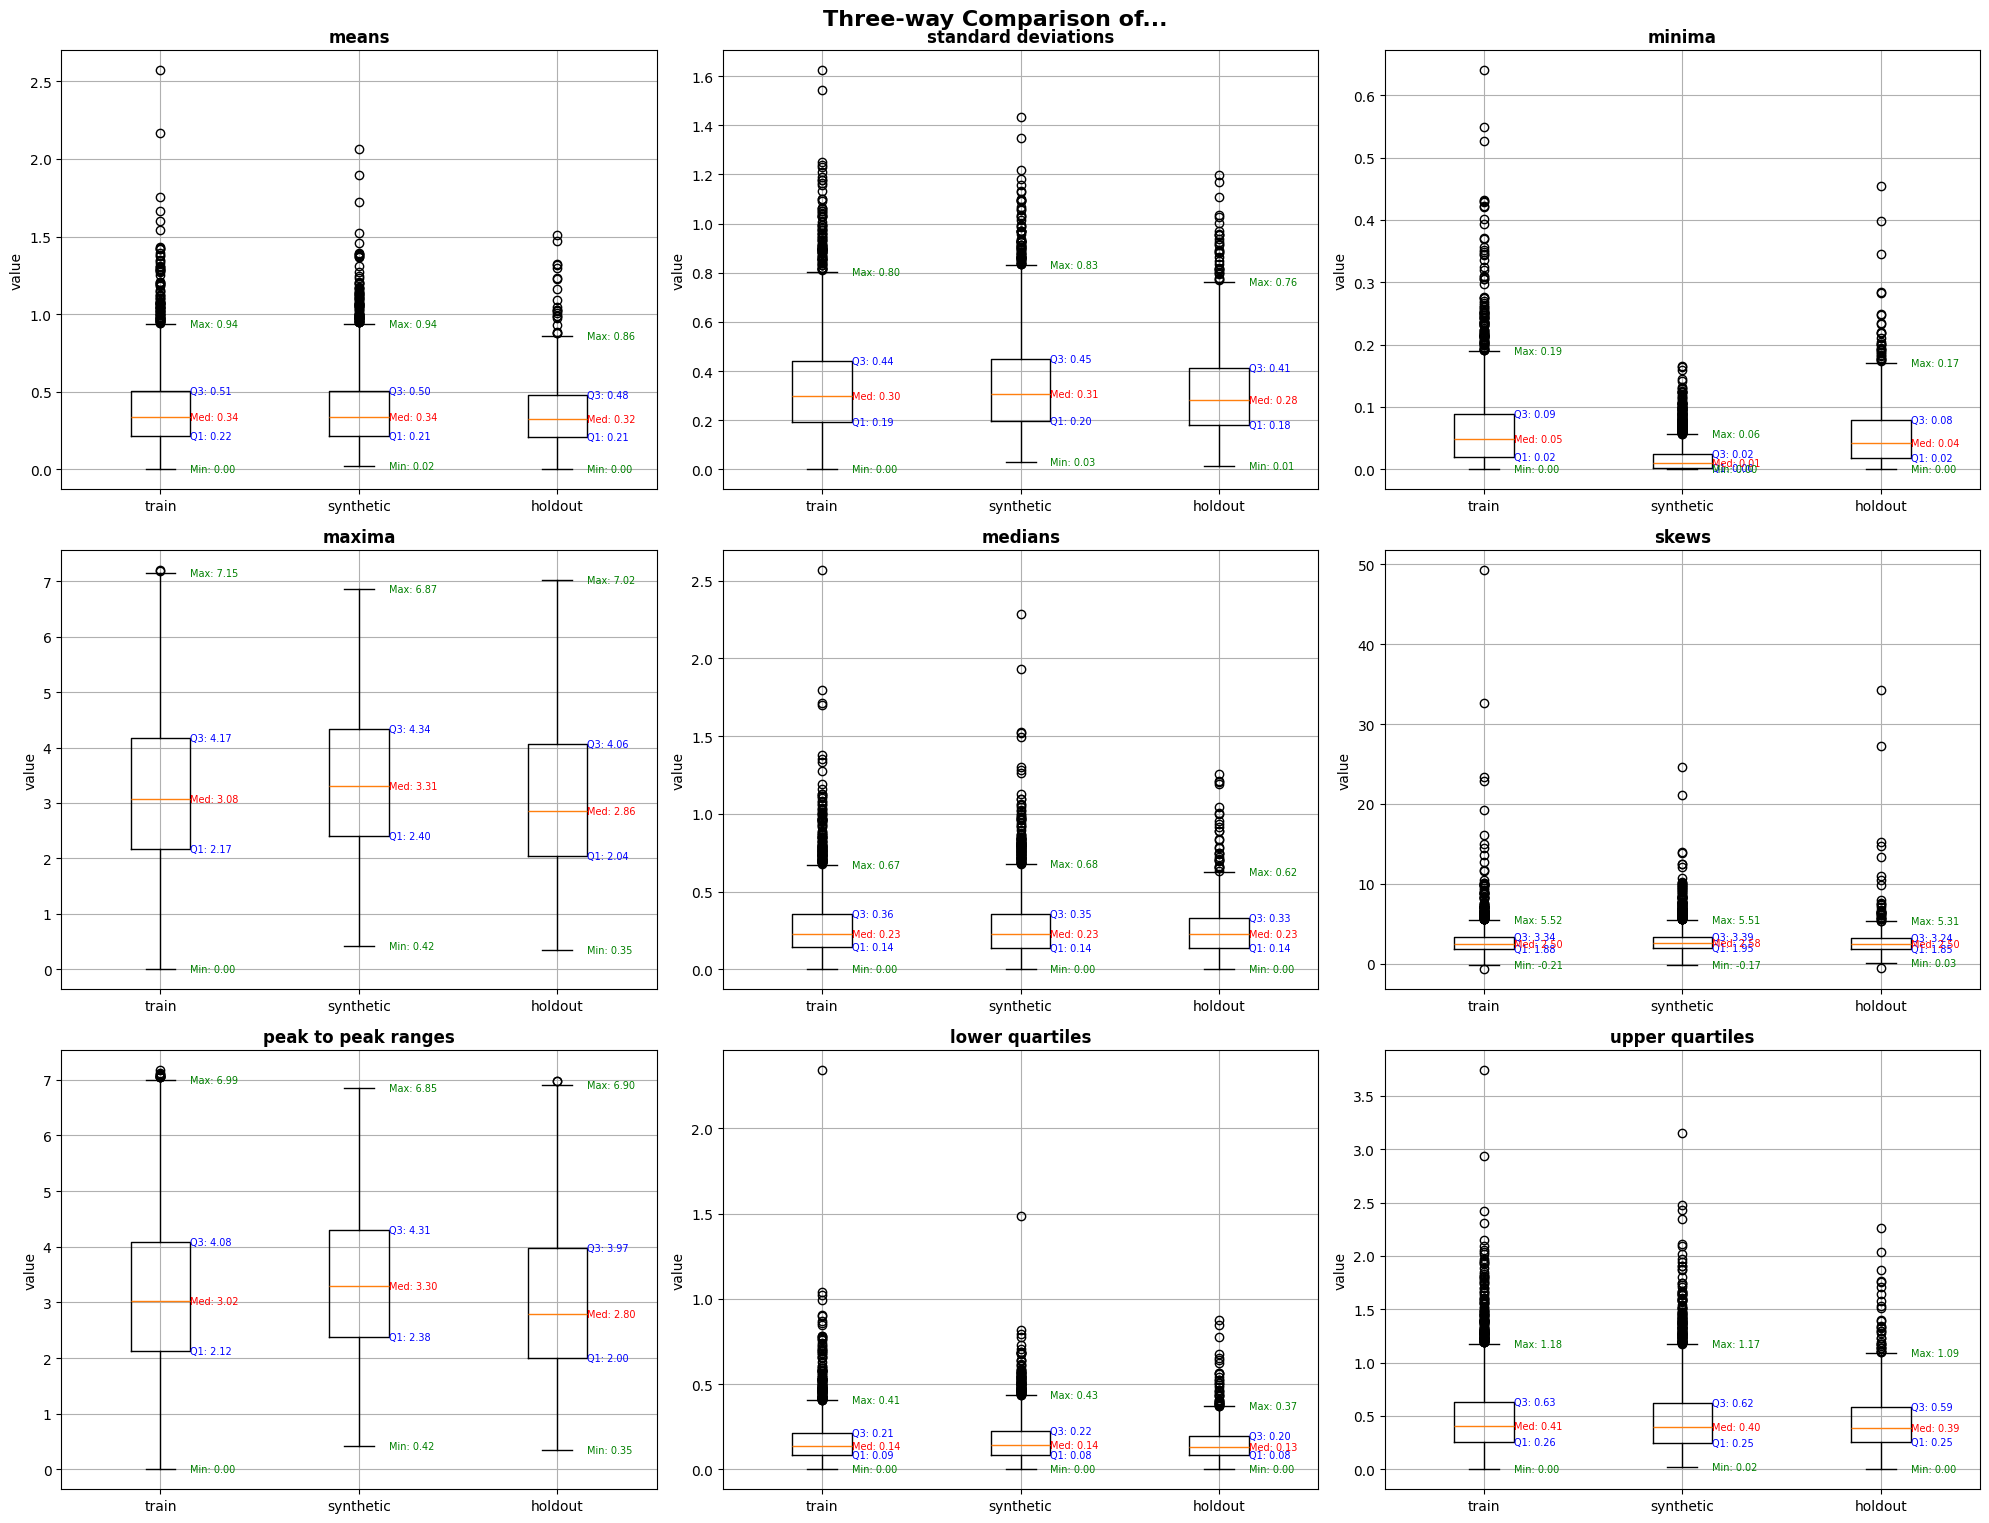

In [7]:
%matplotlib inline
print("\n📊 Creating statistical features comparison for training and synthetic data...")
fig_stats = plot_stats(real_features, synthetic_features, holdout_features)
plt.show()

#### 3. Trend comparison to see if hourly, daily, weekly and monthly trends are captured

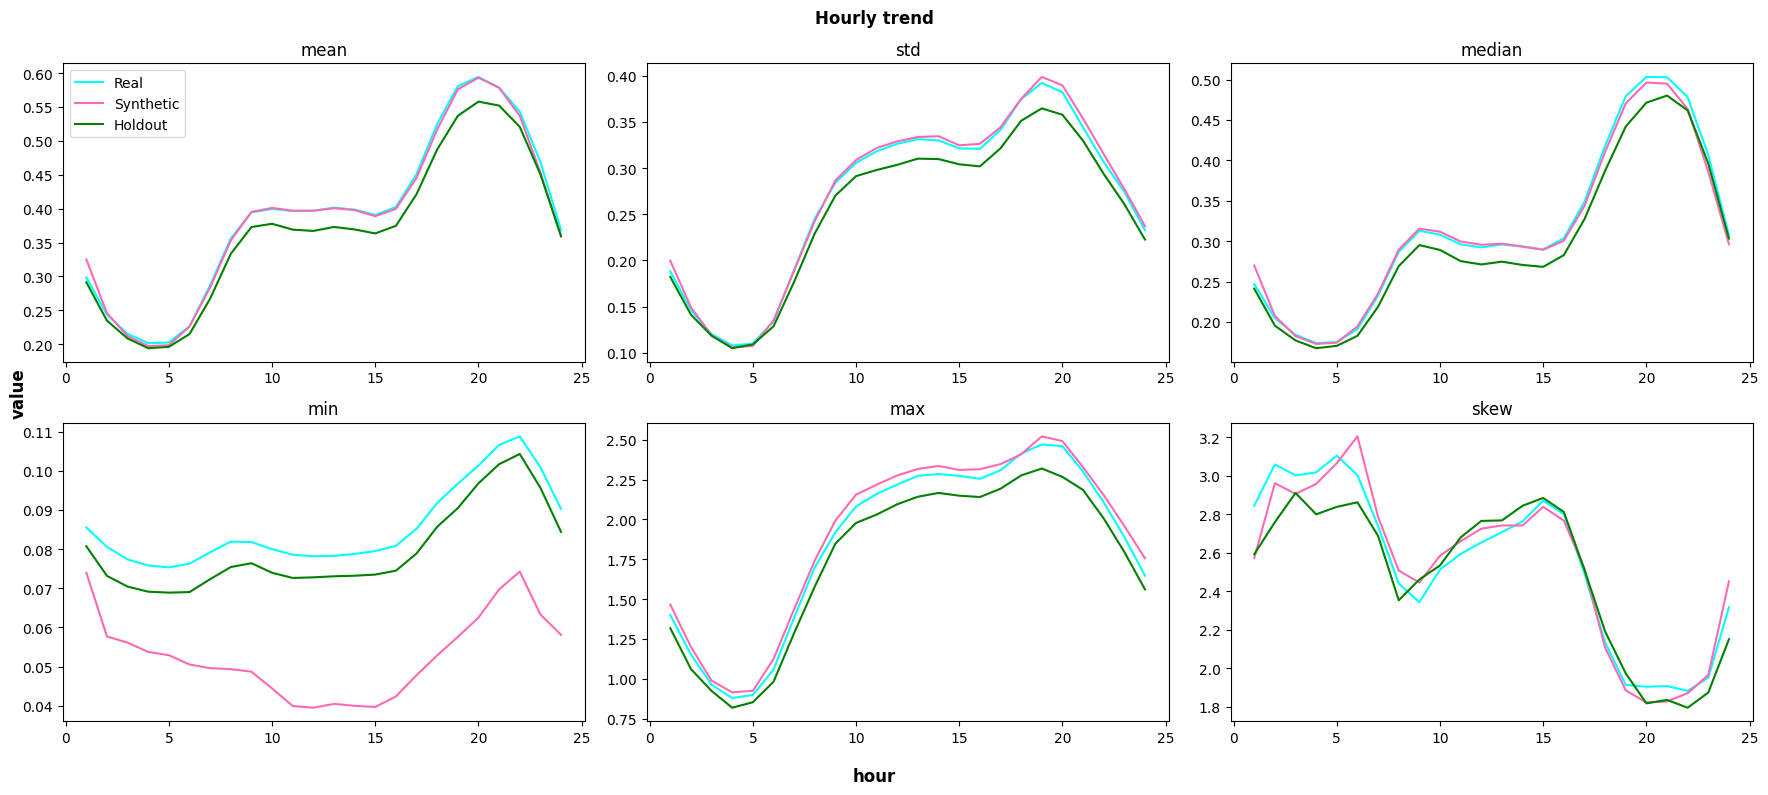

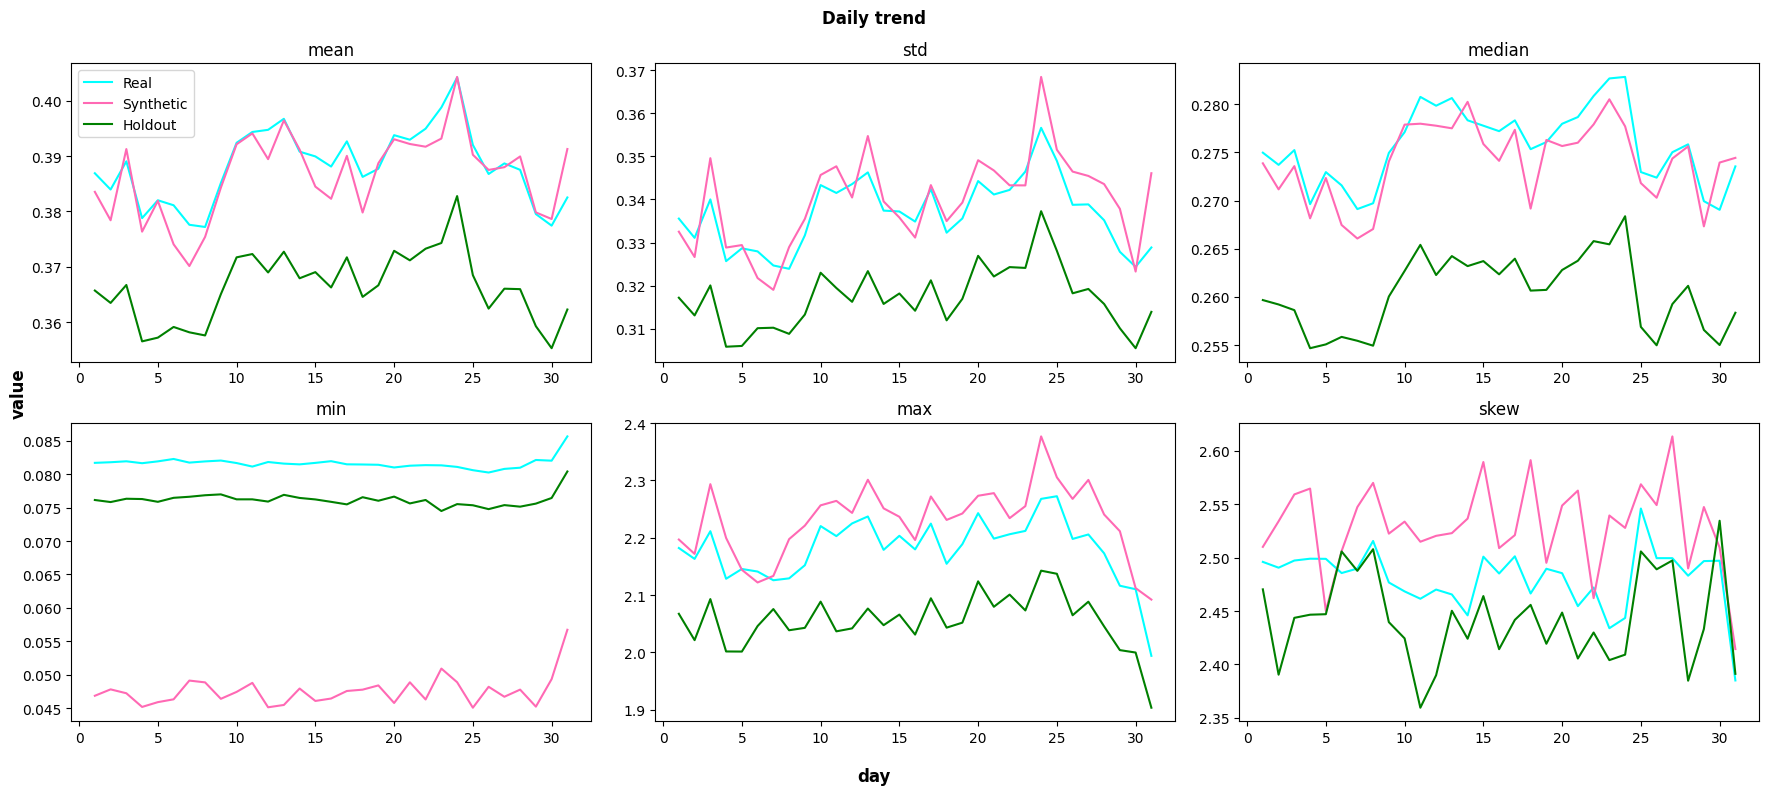

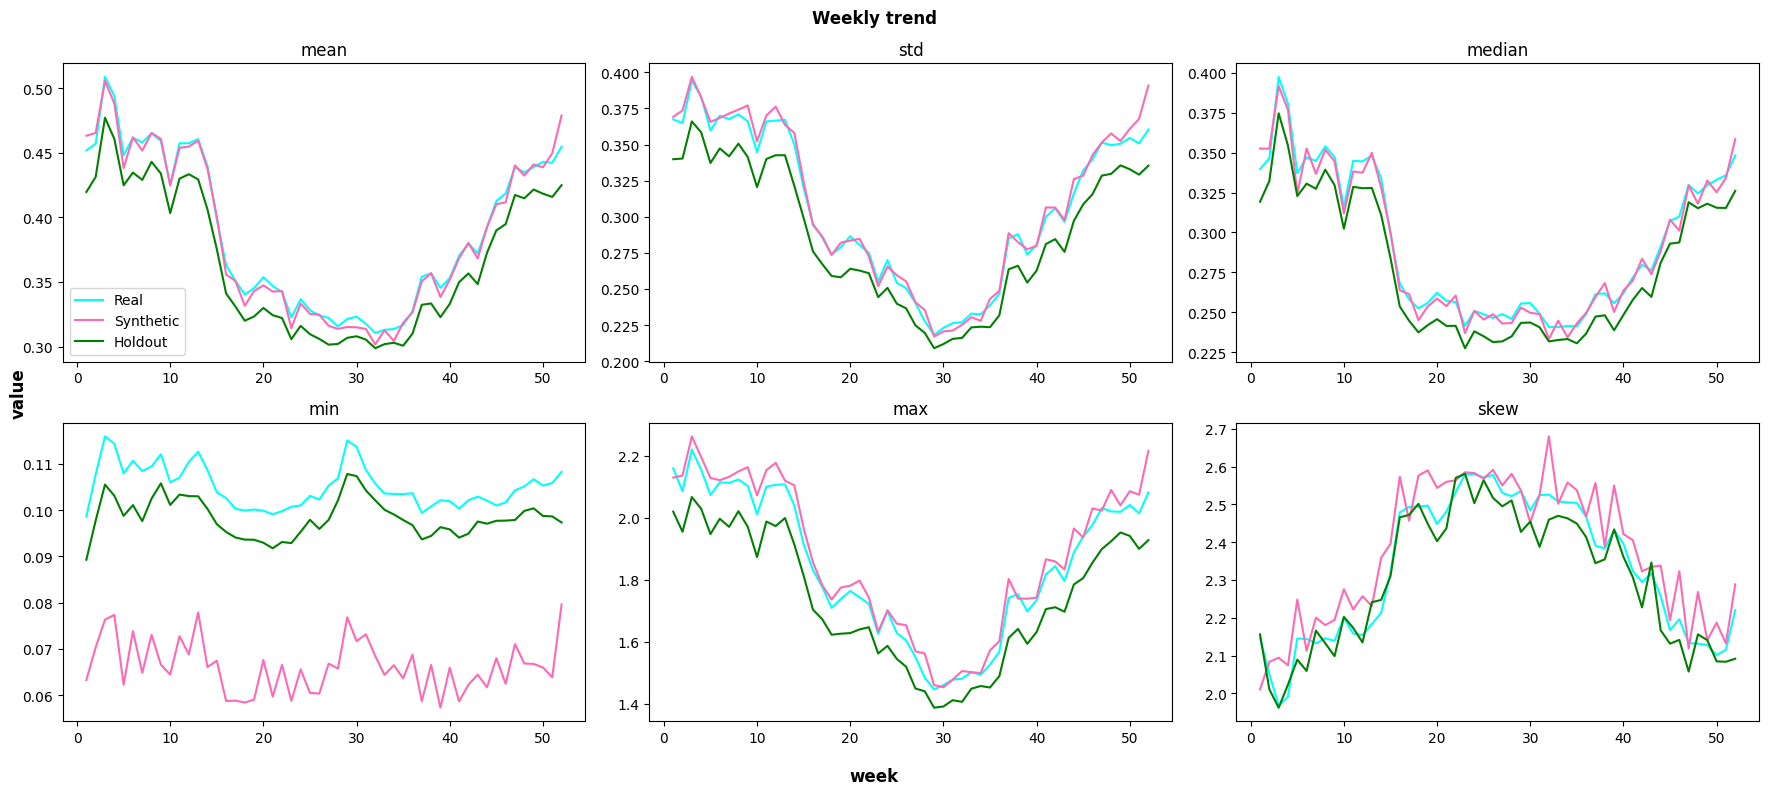

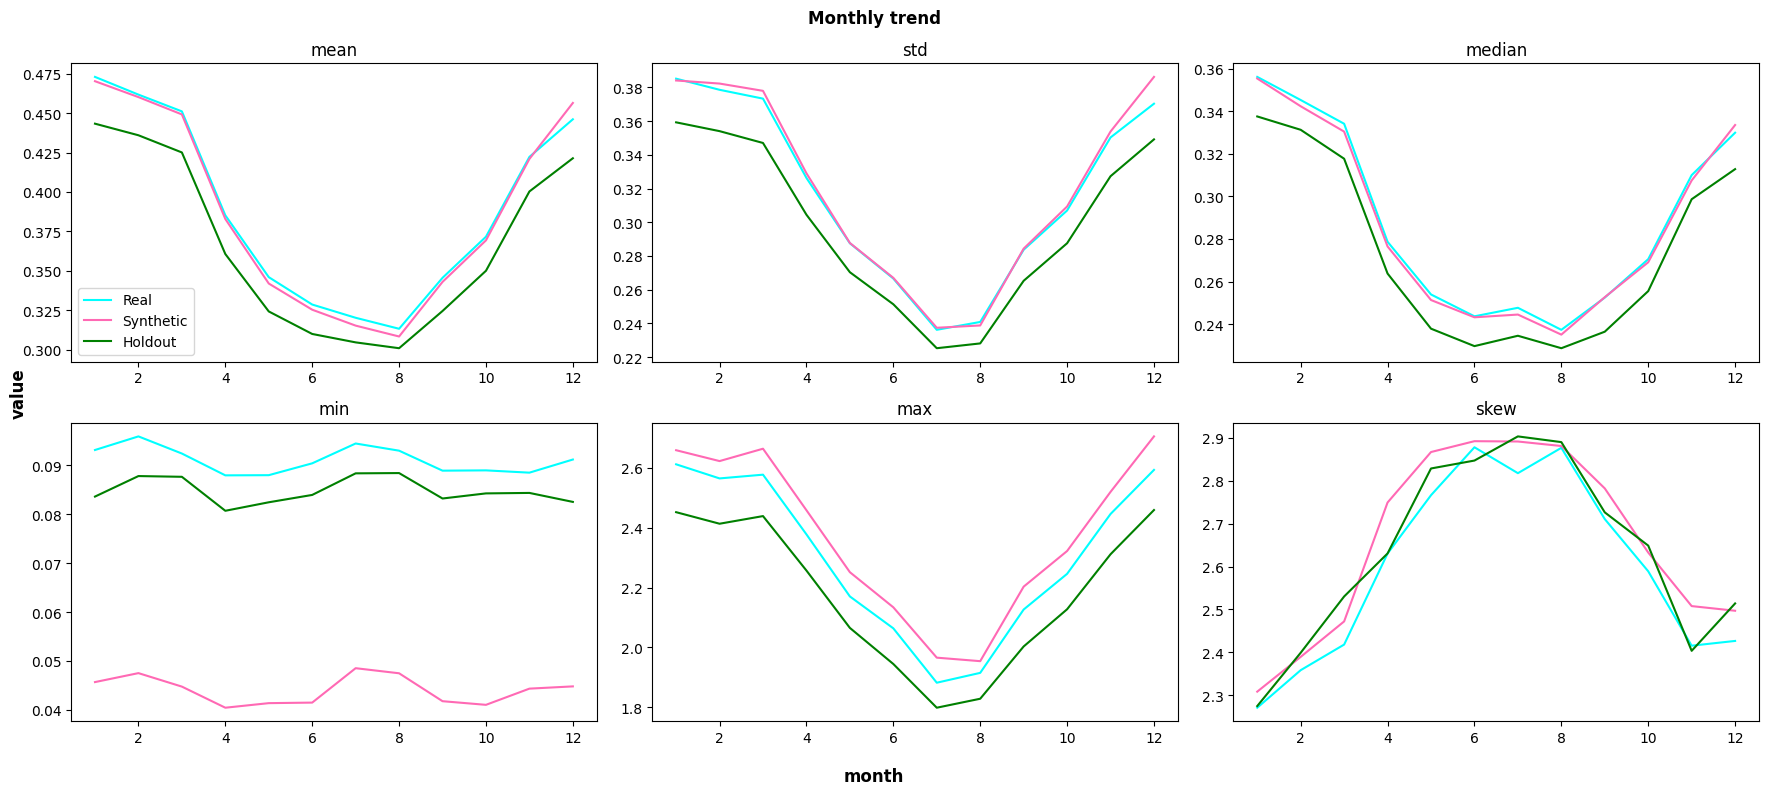

In [8]:
# compute trends for synthetic, real and holdout data
trendSynth_dict = compute_trends(synthetic_data_array, arr_dt)
trendReal_dict = compute_trends(real_data_array, arr_dt)
trendHoldout_dict = compute_trends(holdout_data_array, arr_dt)

trend_plot_dict = plot_mean_trends(trendReal_dict, trendSynth_dict, trendHoldout_dict)


### 🔄 Step 3: Retrain the model for 5 additional epochs

Now we retrain the model for 5 additional epochs to demonstrate loading, training and saving of the model. 


In [11]:
# Load model parameters for retraining
from model.WGAN_params import params

# Set up parameters for retraining
params['epochCount'] = 5  # Only 5 epochs for demonstration
params['outputFormat'] = '.npy'
params['saveFreq'] = 5  # Save at the end of the retraining
params['saveModels'] = True
params['savePlots'] = False  # We'll create our own plots
params['saveSamples'] = False
params['checkForMinStats'] = 0

# Create output directory for retraining
retrain_output_path = Path("showcase_retrain_demo")
retrain_output_path.mkdir(exist_ok=True)

print(f"📂 Retraining output path: {retrain_output_path}")
print(f"⚙️ Training for {params['epochCount']} epochs")
print(f"💾 Saving models every {params['saveFreq']} epochs")

📂 Retraining output path: showcase_retrain_demo
⚙️ Training for 5 epochs
💾 Saving models every 5 epochs


In [12]:
print("🚀 Now let's retrain the model for 5 additional epochs...")
# Initialize the GAN model with the existing trained model
print("\n🔄 Initializing GAN model...")
model = GAN(
    dataset=train_data,
    params=params,
    outputPath=retrain_output_path,
    modelType='WGAN',
    modelStatePath=MODEL_PATH,  # Load our existing model
    logStats=True,
    wandb=None,  # No wandb for demo
    useMarimo=False
)

print("✅ Model initialized with pre-trained weights!")
print(f"🎯 Starting retraining for {params['epochCount']} epochs...")

# Start retraining
model.train()

print("\n🎉 Retraining completed!")

🚀 Now let's retrain the model for 5 additional epochs...

🔄 Initializing GAN model...
Using 'WGAN'.
Successfully imported existing model!
✅ Model initialized with pre-trained weights!
🎯 Starting retraining for 5 epochs...


 40%|████      | 2/5 [00:15<00:22,  7.64s/it]

Successfully saved model to showcase_retrain_demo/models/epoch_2/epoch_2.pt


 60%|██████    | 3/5 [00:22<00:14,  7.39s/it]

Deleted previous model at showcase_retrain_demo/models/epoch_2
Successfully saved model to showcase_retrain_demo/models/epoch_3/epoch_3.pt


100%|██████████| 5/5 [00:36<00:00,  7.34s/it]


Deleted previous model at showcase_retrain_demo/models/epoch_3
Successfully saved model to showcase_retrain_demo/models/epoch_5/epoch_5.pt

🎉 Retraining completed!


## 📊 Model Performance Evaluation Metric

As the model performance jumps slightly from epoch to epoch, we created a sophisticated composite metric to save only models, plots and synthetic data if the initial score is beaten. The new lower score is then used as benchmark and no model run which achieves higher scores will be saved. This ensures we only preserve improved model versions during training. It is unlikely that the model will generate better results in the next five training epochs, as it has already been trained extensively. Anyways, for showcase purposes, we will save the 5th training iteration and re-generate the plots for comparison.

### 🔢 Detailed Score Calculation 

The composite score used to estimate model performance during training combines two essential components with equal weighting (50% each):

#### 1. **Histogram Similarity (50% weight)**
- **Method**: Root Mean Square Error (RMSE) between normalized histograms
- **Process**: 
  - Flattens both real and synthetic data arrays
  - Creates density histograms with 50 bins using consistent range (min/max across both datasets)
  - Computes RMSE: `√(mean((hist_real - hist_synthetic)²))`
- **Lower values = better performance** (perfect match = 0)

#### 2. **Profile Features Distance (50% weight)**
- **Statistical Features Analyzed** (9 total):
    1) Mean 
    2) Standard Deviation 
    3) Minimum
    4) Maximum
    5) Median
    6) Skewness
    7) Peak-to-Peak Range
    8) Lower Quartile (25%)
    9) Upper Quartile (75%)
- **Normalization Process**:
  - Z-score normalization using reference statistics from first evaluation
  - For each feature type: `(synthetic_feature - reference_mean) / reference_std`
- **Distance Calculation**:
  - Computes mean and standard deviation of each normalized feature across profiles
  - Creates feature statistics vector (18 elements: 9 means + 9 stds)
  - Calculates MSE against reference target (vector of ones)
  - Formula: `mean((reference_stats - synthetic_stats)²)`

#### 3. **Final Composite Score**
```
Final Score = 0.5 × (Histogram_Similarity_Normalized) + 0.5 × (Profile_Features_Distance_Normalized)
```

**Normalization**: Both components are divided by their reference values from the first evaluation to ensure comparable scales.

**Score Interpretation**: 
- **Lower scores indicate better performance**
- **Score ≈ 1.0**: Performance similar to first evaluation
- **Score < 1.0**: Improved performance (better than baseline)
- **Score > 1.0**: Degraded performance (worse than baseline)

This comprehensive metric ensures that saved models not only match the overall data distribution (histogram similarity) but also preserve the detailed statistical characteristics of individual energy consumption profiles (feature-level analysis). The equal weighting ensures balanced optimization across both global and local data properties.

### 💾 Step 4: Load the retrained model and generate new synthetic data

In [18]:
print("🔄 Loading the retrained model...")

# Find the latest saved model from retraining
models_dir = retrain_output_path / "models"
if models_dir.exists():
    # Get all epoch directories
    epoch_dirs = [d for d in models_dir.iterdir() if d.is_dir() and d.name.startswith('epoch_')]
    if epoch_dirs:
        # Sort by epoch number to get the latest
        latest_epoch_dir = sorted(epoch_dirs, key=lambda x: int(x.name.split('_')[1]))[-1]
        retrained_model_path = latest_epoch_dir / f"{latest_epoch_dir.name}.pt"
        print(f"📂 Found retrained model: {retrained_model_path}")
    else:
        print("❌ No epoch directories found in models directory")
        retrained_model_path = None
else:
    print("❌ Models directory not found")
    retrained_model_path = None

if retrained_model_path and retrained_model_path.exists():
    print("🤖 Generating synthetic data from retrained model...")
    
    # Generate new synthetic data using the retrained model
    retrained_synthetic_data_array = generate_data_from_saved_model(retrained_model_path, n_profiles=n_profiles)
    retrained_synthetic_data_values = retrained_synthetic_data_array[:, 1:].astype(np.float32)
    
    # Convert to DataFrame
    retrained_synthetic_df = pd.DataFrame(
        retrained_synthetic_data_values,
        index=train_data.index[:len(retrained_synthetic_data_values)],
        columns=[f"retrained_synthetic_{i}" for i in range(retrained_synthetic_data_values.shape[1])]
    )
    
    print(f"✅ Generated synthetic data from retrained model!")
    print(f"📊 Retrained synthetic data shape: {retrained_synthetic_data_values.shape}")
    
    print(f"\n📊 Retrained synthetic data statistics:")
    print(f"   Min value: {retrained_synthetic_df.min().min():.4f}")
    print(f"   Max value: {retrained_synthetic_df.max().max():.4f}")
    print(f"   Mean value: {retrained_synthetic_df.mean().mean():.4f}")
    print(f"   Std value: {retrained_synthetic_df.std().mean():.4f}")
else:
    print("❌ Could not find retrained model file")
    retrained_synthetic_data_values = None


🔄 Loading the retrained model...
📂 Found retrained model: showcase_retrain_demo/models/epoch_5/epoch_5.pt
🤖 Generating synthetic data from retrained model...
Successfully loaded model from showcase_retrain_demo/models/epoch_5/epoch_5.pt
✅ Generated synthetic data from retrained model!
📊 Retrained synthetic data shape: (8760, 3050)

📊 Retrained synthetic data statistics:
   Min value: 0.0000
   Max value: 6.8704
   Mean value: 0.3853
   Std value: 0.3371


### 📊 Step 5: Compare results before and after retraining

In the following the trends are again plotted showing the difference between the old model, the training data and the retrained model.

📊 Creating comparison visualizations...


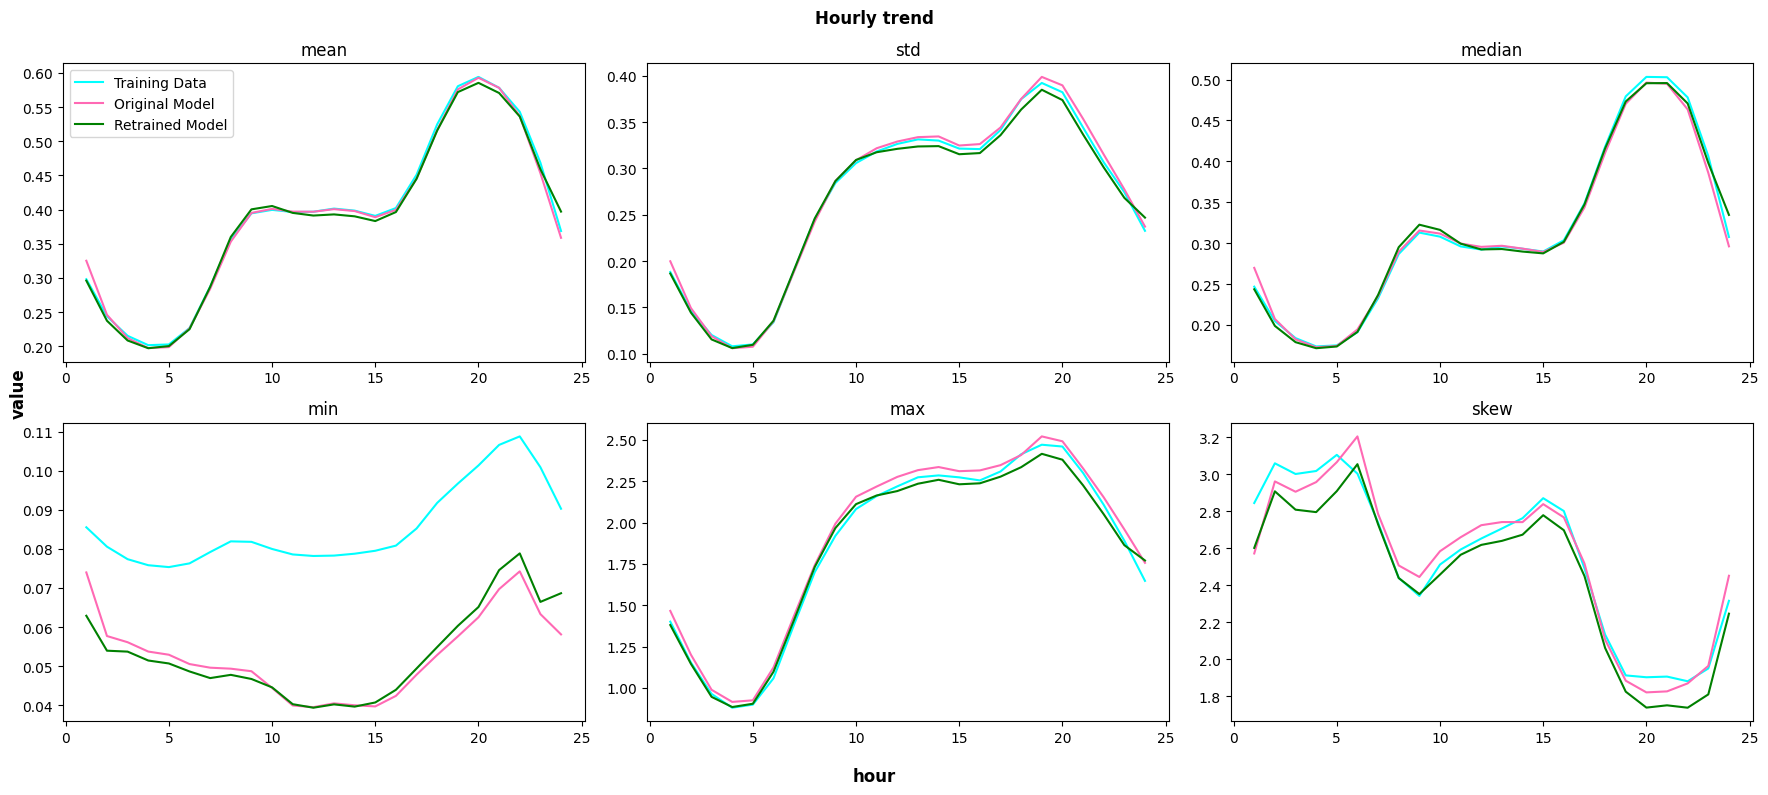

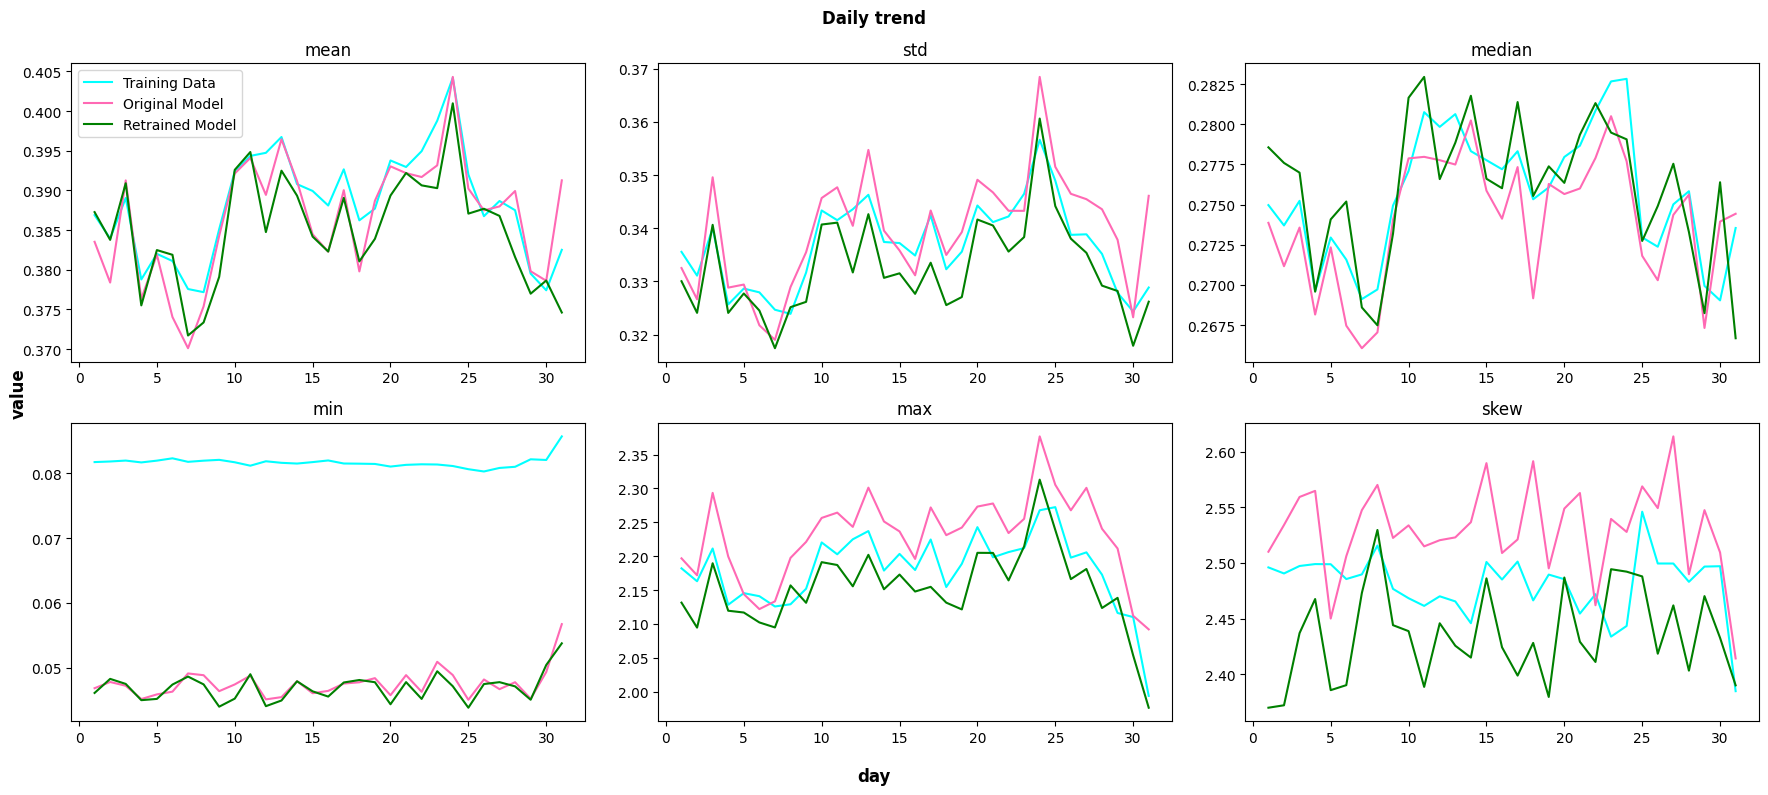

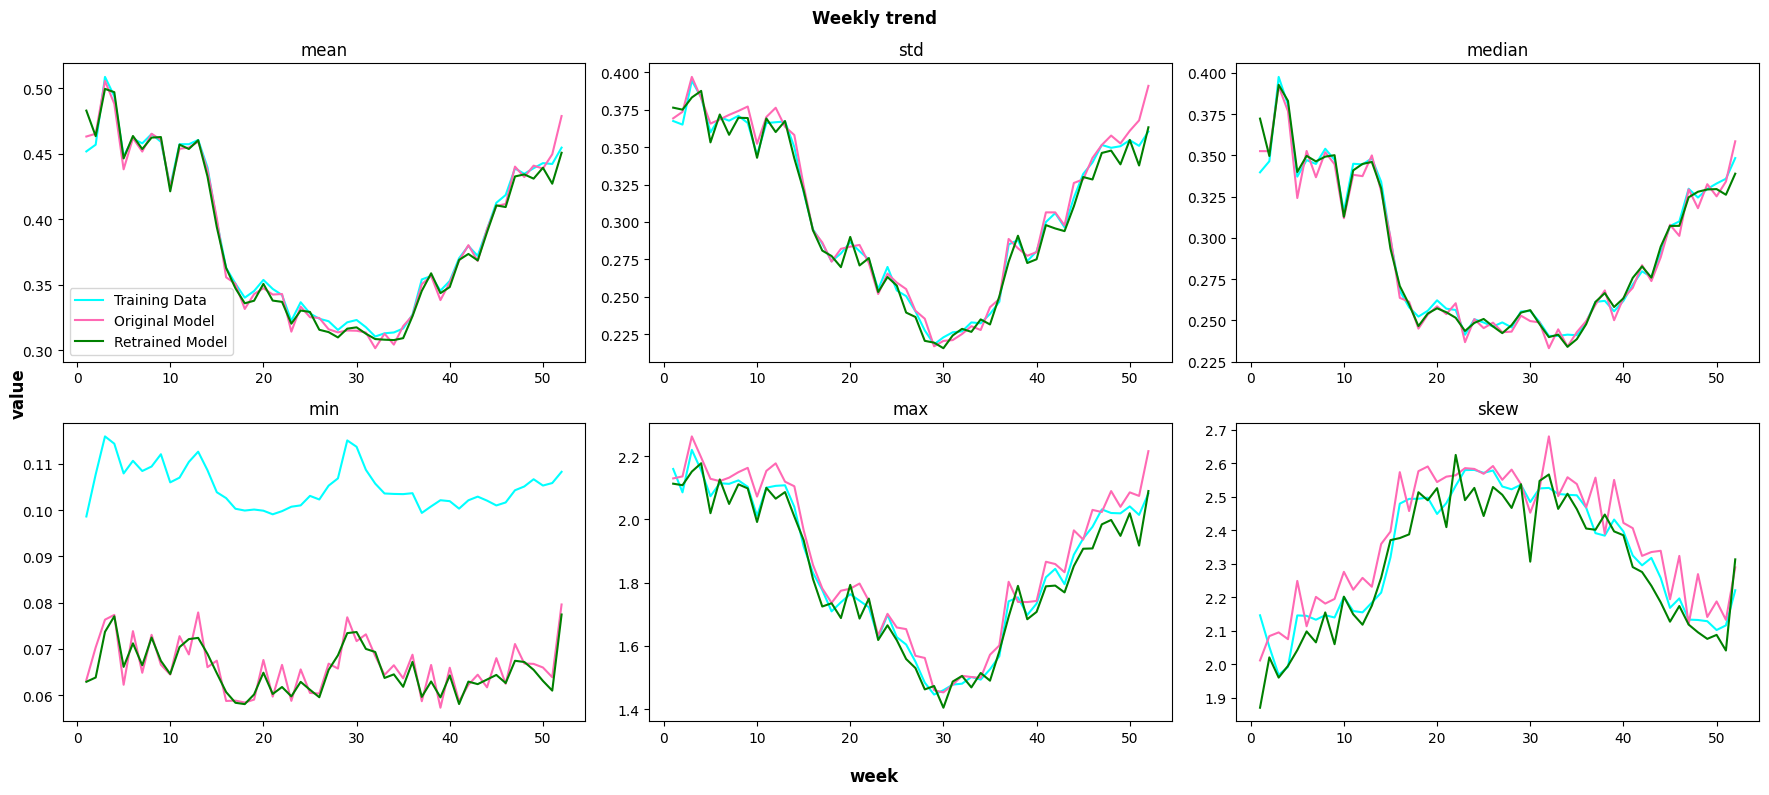

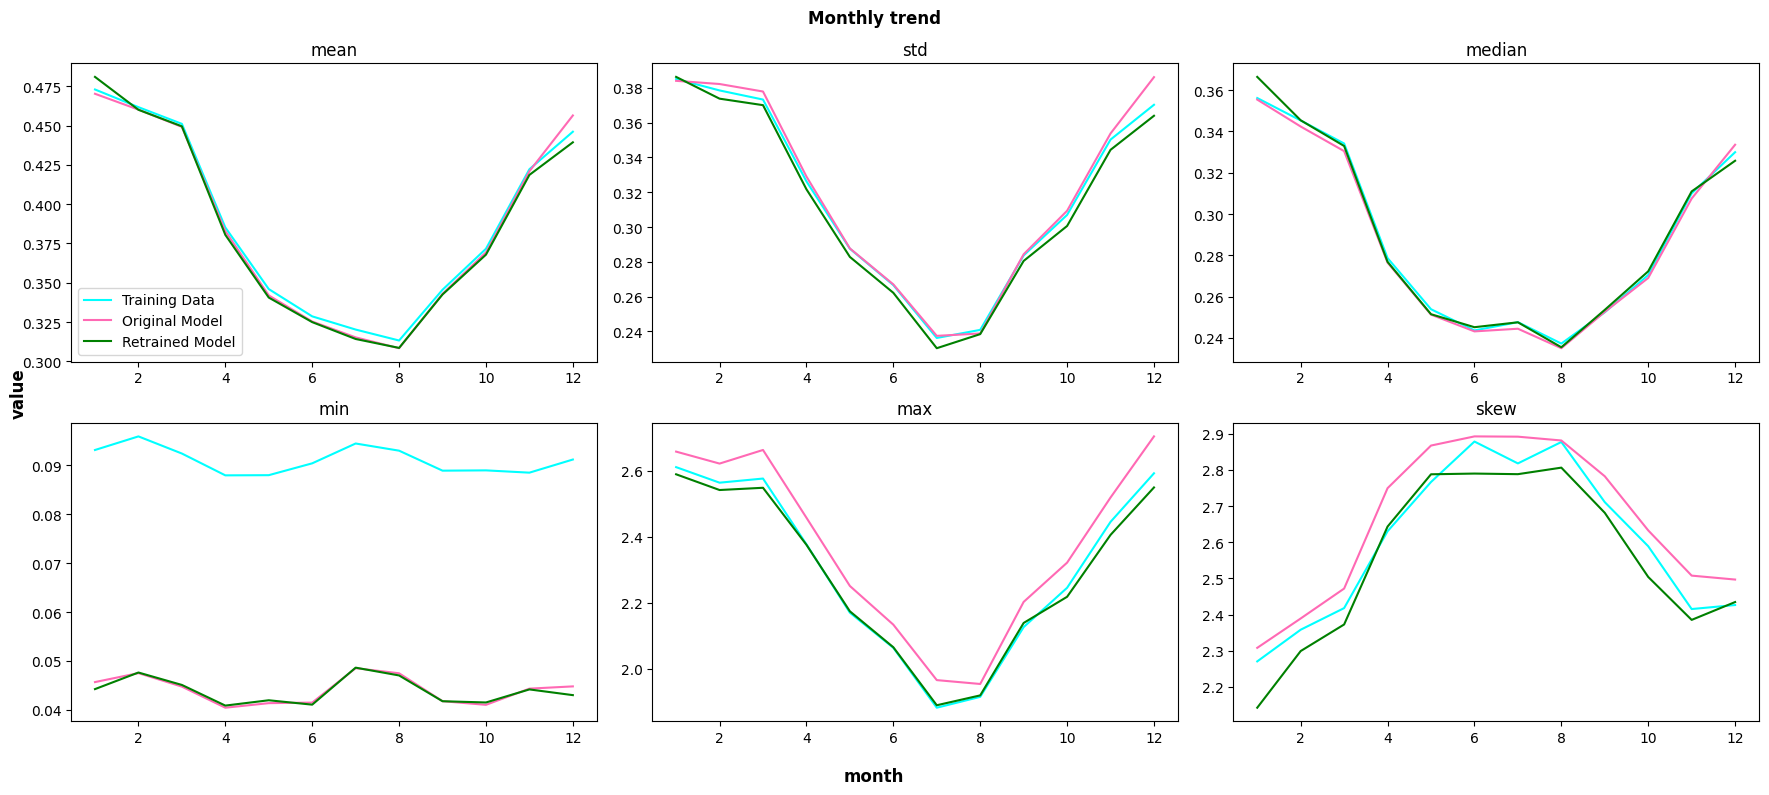

In [25]:
print("📊 Creating comparison visualizations...")
# compute trends for old and new synthetic and training data
trendSynth_dict_old = compute_trends(synthetic_data_array, arr_dt)
trendSynth_dict_new = compute_trends(retrained_synthetic_data_values, arr_dt)
trendReal_dict = compute_trends(real_data_array, arr_dt)

trend_plot_dict = plot_mean_trends(trendReal_dict, trendSynth_dict_old, trendSynth_dict_new)  

# Customize legends for each plot
for plot_name, fig in trend_plot_dict.items():
    # Get all axes from the figure
    axes = fig.get_axes()
    
    # Update legend for the first subplot (which contains the legend)
    if len(axes) > 0:
        # Get the first axis (which should have the legend)
        ax_with_legend = axes[0]
        
        # Update the legend with custom labels
        handles, labels = ax_with_legend.get_legend_handles_labels()
        if len(handles) >= 3:  # Make sure we have all three lines
            new_labels = ['Training Data', 'Original Model', 'Retrained Model']
            ax_with_legend.legend(handles, new_labels)
    
    # Optional: Update the title to be more descriptive
    # fig.suptitle(f'{plot_name.replace("_", " ").title()} - Model Comparison', fontweight='bold')

# Display the plots
for plot_name, fig in trend_plot_dict.items():
    fig.show()

## 🎯 Showcase Complete!

This notebook has demonstrated the complete workflow of working with GAN models for synthetic energy data generation:

### What We Accomplished:

1. **🤖 Model Loading**: Successfully loaded a pre-trained WGAN model that was trained for 4950 epochs
2. **📊 Data Generation**: Generated synthetic energy consumption profiles using the model
3. **📈 Visualization**: Used the built-in plotting tools to compare real vs synthetic data:
   - Value distribution plots
   - Statistical feature comparisons
   - Mean profile comparisons
4. **🔄 Retraining**: Demonstrated how to continue training an existing model for 5 additional epochs
5. **💾 Model Management**: Showed how to save and load models during the training process
6. **📊 Performance Analysis**: Compared metrics before and after retraining to evaluate improvements

### Key Takeaways:

- The GAN model generates realistic synthetic energy consumption profiles
- The retraining process allows for model refinement and adaptation
- Built-in visualization tools provide comprehensive analysis capabilities
- The modular design allows for easy model management and experimentation

### Potential Applications:

- **Data Augmentation**: Generate additional training data for other ML models
- **Privacy Protection**: Create synthetic datasets while preserving data privacy
- **Scenario Testing**: Generate realistic consumption patterns for system testing
- **Research**: Study energy consumption patterns without accessing sensitive real data

